In [1]:
import os
from math import pi

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c

import jdgsim
from jdgsim import construct_initial_state
from jdgsim.integrators import leapfrog
from jdgsim.dynamics import direct_acc
from jdgsim.option_classes import SimulationConfig, SimulationParams, NFWParams
from jdgsim.initial_condition import Plummer_sphere, ic_two_body
from jdgsim.utils import center_of_mass
from jdgsim.time_integration import time_integration
from jdgsim.units import CodeUnits

# Plummer Sphere

In [38]:
self_G = c.G.to(code_length**3 / code_mass / u.s**2) 

self_G = self_G * (code_mass/code_length**3)
code_time = (1/self_G)**(1/2)
code_time.to(u.Gyr).value

471.48299511187315

In [ ]:
code_length = 1.0 * u.kpc
code_mass = 1.0 * u.Msun
G=1 
code_units = CodeUnits(code_length, code_mass, G=G)

In [ ]:
code_time

In [14]:
(1*code_units.code_time).to(u.yr)

UnitConversionError: 'code_time' and 'yr' (time) are not convertible

In [ ]:
# Define the 
config = SimulationConfig(N_particles=10_000, 
                          return_snapshots=True, 
                          num_snapshots=100, 
                          num_timesteps=1_000, 
                          external_accelerations=(), 
                          softening=1e-5) #default values

params = SimulationParams(t_end = (100 * u.Myr).to(code_units.code_time).value,  
                          Plummer_a=(10 * u.kpc).to(code_units.code_length).value,
                          NFW_params = NFWParams(Mvir=1e4, ),
                          G=c.G.to(code_units.code_length ** 3 / code_units.code_mass / code_units.code_time ** 2).value, ) 

print(config)
print(params)

SimulationConfig(N_particles=10000, dimensions=3, return_snapshots=True, num_snapshots=100, fixed_timestep=True, num_timesteps=1000, softening=1e-05, integrator=0, acceleration_scheme=0, external_accelerations=())
SimulationParams(G=1, t_end=100, NFW_params=NFWParams(Mvir=1000.0, r_s=15.3, d_c=7.18, c=None), Plummer_a=1)


In [59]:
#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)
rp=10

if len(config.external_accelerations)>0:
    pos, vel, _ = ic_two_body(params.NFW_params.Mvir, 1, rp=rp, e=0., config=config, params=params)
    velocites = velocities + vel[1]
    positions = positions + pos[1]

#initialize the initial state
initial_state = construct_initial_state(positions, velocities)


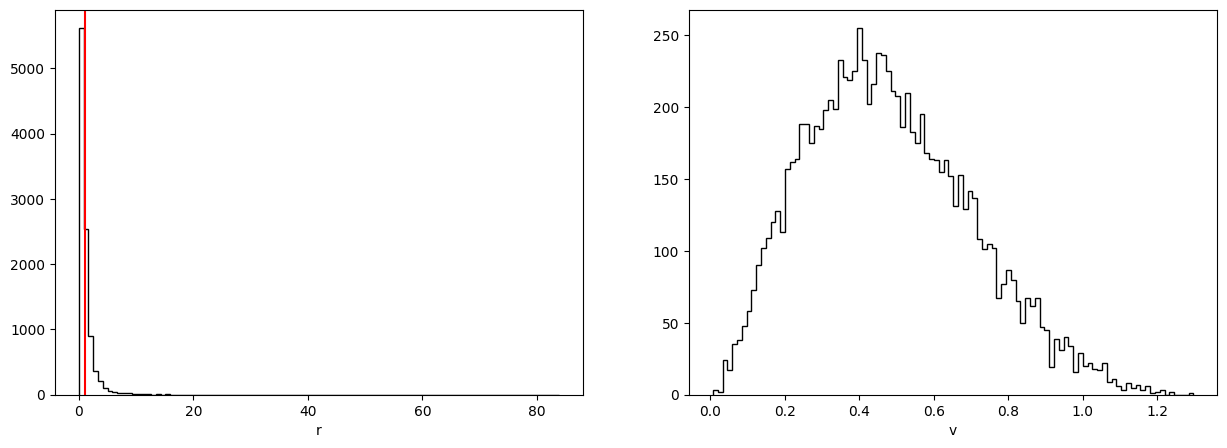

In [56]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist(jnp.linalg.norm(positions, axis=1), bins=100, histtype='step', color='k')
ax.axvline(params.Plummer_a, color='r', label='Plummer a')
ax.set_xlabel('r')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm(velocities, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v')
plt.show()

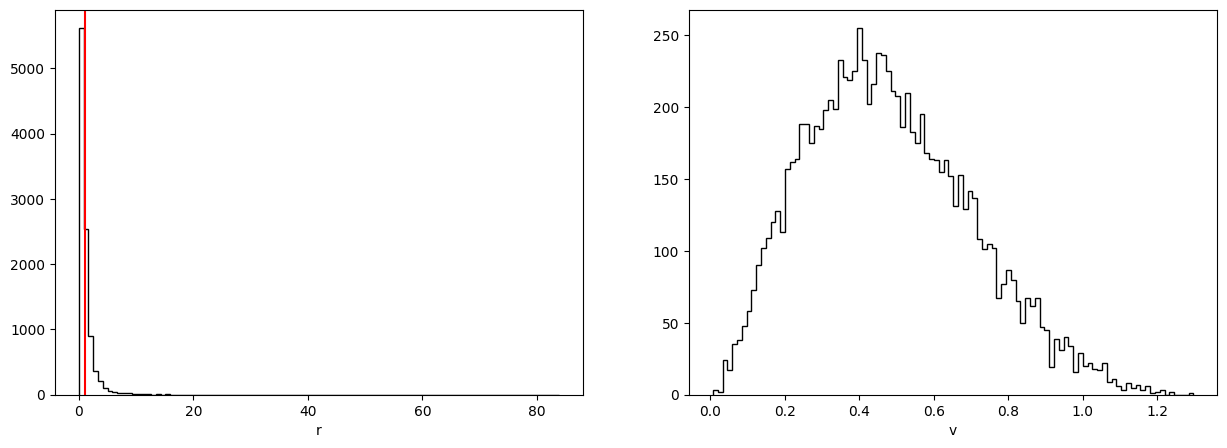

In [57]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist(jnp.linalg.norm(positions, axis=1), bins=100, histtype='step', color='k')
ax.axvline(params.Plummer_a, color='r', label='Plummer a')
ax.set_xlabel('r')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm(velocities, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v')
plt.show()

In [30]:
if config.return_snapshots: 
    snapshots = time_integration(initial_state, mass, config, params)
else:
    final_state = time_integration(initial_state, mass, config, params)


/tmp/ipykernel_2550524/3744237133.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


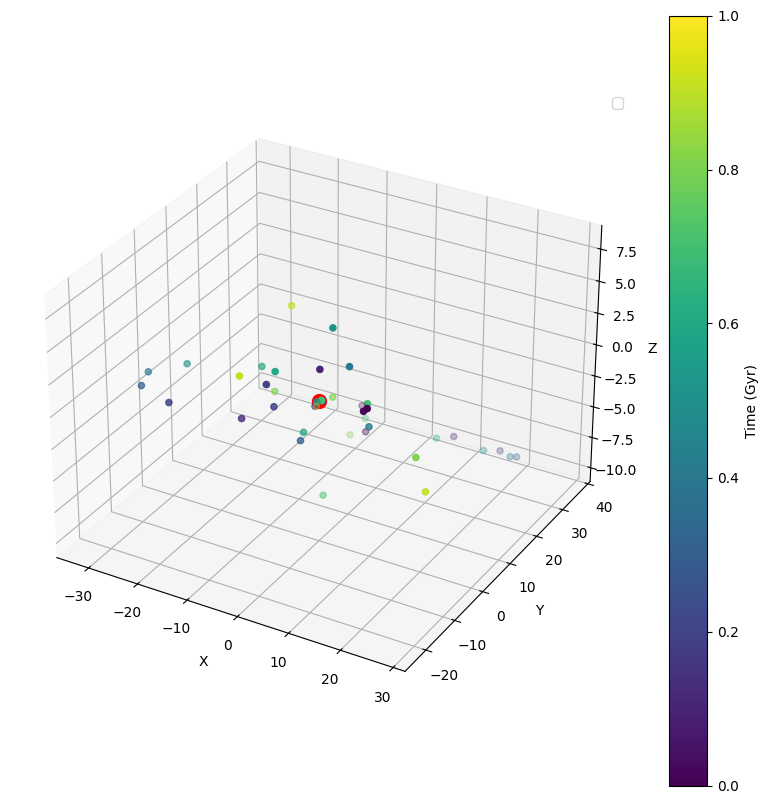

In [31]:
fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')

# Normalize the times to the range [0, 1] for colormap
norm_times = (snapshots.times - snapshots.times.min()) / (snapshots.times.max() - snapshots.times.min())

# Generate colors using a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(norm_times)
for i in range(0, len(snapshots.states), 10):
    sc = ax.scatter(snapshots.states[i, :, 0, 0], snapshots.states[i, :, 0, 1], snapshots.states[i, :, 0, 2] , color=colors[i])

ax.scatter(0, 0, 0, c='r', s=100)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


cbar = plt.colorbar(sc)
cbar.set_label('Time (Gyr)')
plt.legend()


(-1.0, 1.0)

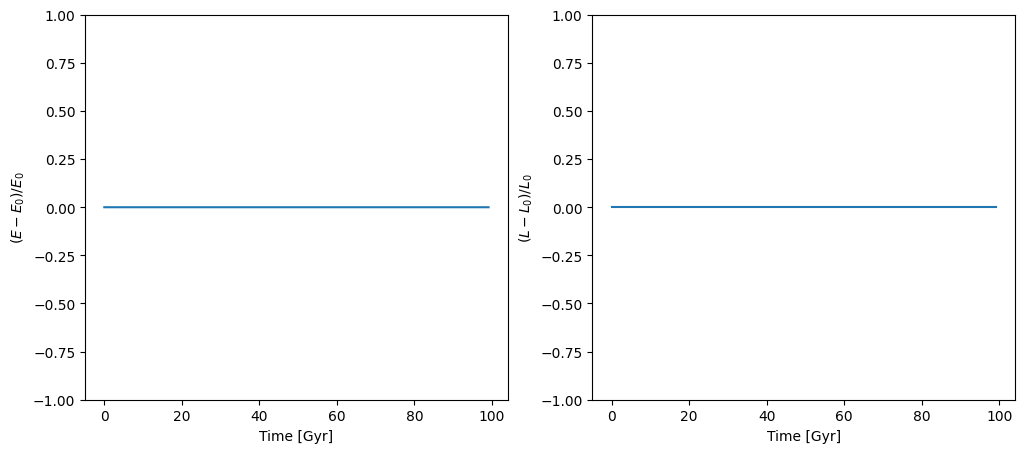

In [32]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121)
Delta_E = ((snapshots.total_energy - snapshots.total_energy[0])/snapshots.total_energy[0])
ax.plot(snapshots.times, Delta_E, )
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel(r'$(E - E_0)/E_0$')
ax.set_ylim(-1, 1)

ax = fig.add_subplot(122)
Delta_AngMom = ((snapshots.angular_momentum - snapshots.angular_momentum[0])/snapshots.angular_momentum[0])
ax.plot(snapshots.times, Delta_AngMom[:, 2], )
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel(r'$(L - L_0)/L_0$')
ax.set_ylim(-1, 1)

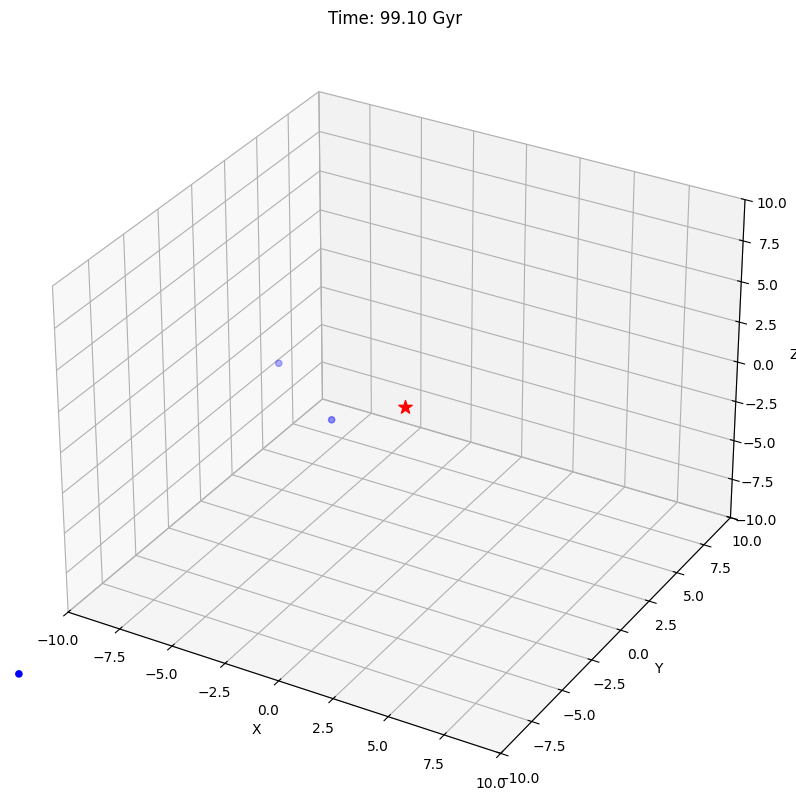

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter

def create_gif_from_snapshots(snapshots, filename='simulation.gif'):
    # Create a figure for plotting
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Initialize the scatter plot
    scatter1 = ax.scatter([], [], [], c='b')
    scatter2 = ax.scatter([], [], [], c='r', marker='*')

    def init():
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        return scatter1, scatter2

    def update(frame):
        ax.clear()
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim(-rp, rp)
        ax.set_ylim(-rp, rp)
        ax.set_zlim(-rp, rp)
        ax.set_title(f'Time: {snapshots.times[frame]:.2f} Gyr')
        scatter1 = ax.scatter(snapshots.states[frame, :, 0, 0], snapshots.states[frame, :, 0, 1], snapshots.states[frame, :, 0, 2], c='b')
        scatter2 = ax.scatter(0, 0, 0, c='r', s=100, marker='*')
        return scatter1, scatter2

    # Create the animation
    anim = FuncAnimation(fig, update, frames=range(0, len(snapshots.states), 1), init_func=init, blit=False)

    # Save the animation as a GIF
    anim.save(filename, writer=PillowWriter(fps=10))

# Example usage
create_gif_from_snapshots(snapshots)

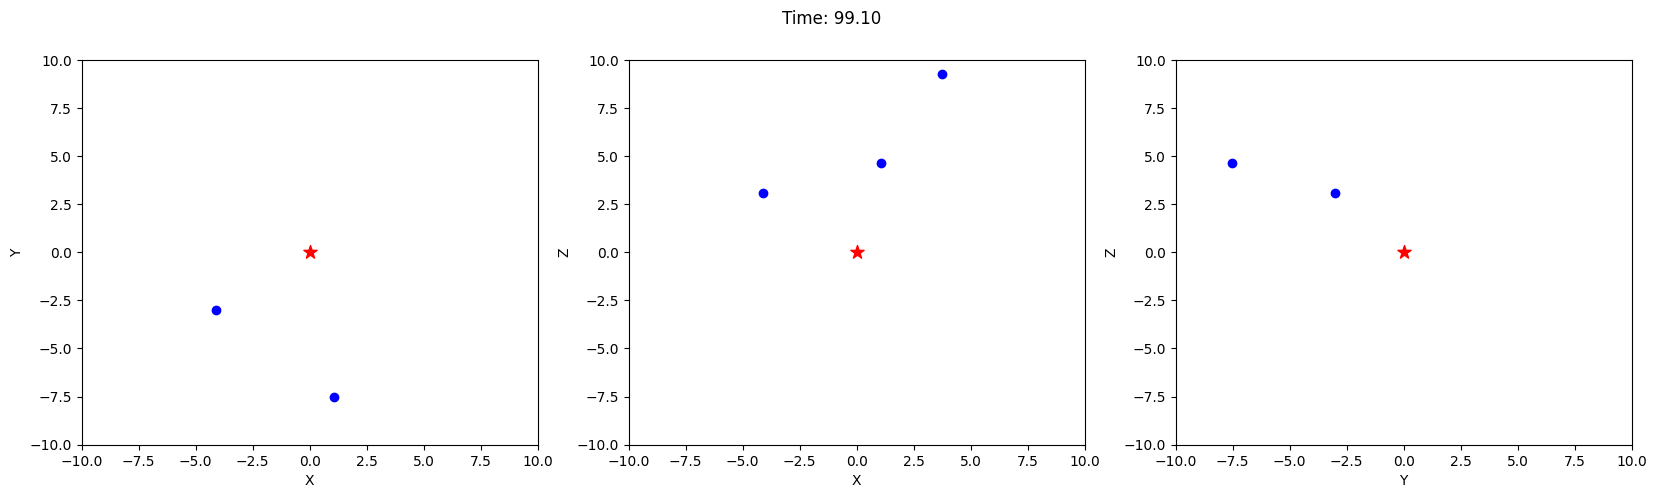

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter

def simulation_projection(snapshots, filename='simulation_projection.gif'):
    # Create a figure for plotting
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    
    # Initialize the scatter plots
    scatter1 = ax1.scatter([], [], c='b')
    scatter2 = ax1.scatter([], [], c='r', marker='*')
    scatter3 = ax2.scatter([], [], c='b')
    scatter4 = ax2.scatter([], [], c='r', marker='*')
    scatter5 = ax3.scatter([], [], c='b')
    scatter6 = ax3.scatter([], [], c='r', marker='*')

    def init():
        for ax in [ax1, ax2, ax3]:
            ax.set_xlim(-rp, rp)
            ax.set_ylim(-rp, rp)
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Z')
        ax3.set_xlabel('Y')
        ax3.set_ylabel('Z')
        return scatter1, scatter2, scatter3, scatter4, scatter5, scatter6

    def update(frame):
        fig.suptitle(f'Time: {snapshots.times[frame]:.2f}')

        for ax in [ax1, ax2, ax3]:
            ax.clear()
            ax.set_xlim(-rp, rp)
            ax.set_ylim(-rp, rp)
        
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        scatter1 = ax1.scatter(snapshots.states[frame, :, 0, 0], snapshots.states[frame, :, 0, 1], c='b')
        scatter2 = ax1.scatter(0, 0, c='r', s=100, marker='*')
        
        ax2.set_xlabel('X')
        ax2.set_ylabel('Z')
        scatter3 = ax2.scatter(snapshots.states[frame, :, 0, 0], snapshots.states[frame, :, 0, 2], c='b')
        scatter4 = ax2.scatter(0, 0, c='r', s=100, marker='*')
        
        ax3.set_xlabel('Y')
        ax3.set_ylabel('Z')
        scatter5 = ax3.scatter(snapshots.states[frame, :, 0, 1], snapshots.states[frame, :, 0, 2], c='b')
        scatter6 = ax3.scatter(0, 0, c='r', s=100, marker='*')
        
        return scatter1, scatter2, scatter3, scatter4, scatter5, scatter6

    # Create the animation
    anim = FuncAnimation(fig, update, frames=range(0, len(snapshots.states), 1), init_func=init, blit=False)

    # Save the animation as a GIF
    anim.save(filename, writer=PillowWriter(fps=10))

# Example usage
simulation_projection(snapshots)